# AI-driven ChemE car Competition

## Manual tunning and control

注意：这里修改了颜色识别的代码。

为了更加可靠的识别颜色，这里使用了HSV颜色代码，HSV的数值代表以下意思：H (Hue): 0–360 degrees；S (Saturation): 0–100 (percent)；V (Value): 0–100 (percent)。

可以使用以下链接挑选颜色：

颜色挑选：https://colorpicker.me/#e5fe1d

上传图片挑选颜色：https://redketchup.io/color-picker

HSV lower color里面的每一项数值需要对应小于HSV upper color，比如hsv_lower = [200, 0 ,0], hsv_upper = [200, 100 ,100]。但从定义上将S和V的数值大意味着更鲜艳更亮的颜色，所以在碘钟反应中选择的浅黄应该对应hsv_upper，深黄对应比如hsv_lower。

Color change threshold指所指定区域内有多少比例的像素处于设定的颜色范围内

In [ ]:
from camera_control import CameraControl
from MKSMotor_USB import MKSMotor, MotorControlUI
import time
import ipywidgets as widgets
from IPython.display import display
import cv2
import threading

# CameraControl
cam_control = CameraControl(digit_cam_id=0, color_cam_id=1)
cam_control.display_UI()

# Configure serial port parameters, Linux/MacOS starts with dev/tty., Windows uses "COM3, COM5" etc.
port="COM4"
baudrate = 38400
motor = MKSMotor(port=port, baudrate=baudrate)  # Motor initialization
motor_ui = MotorControlUI(motor)
motor_ui.display_controls()


## Ready to go competition
### Step 1: Configure your MNIST algorithm
请先加载你的MNIST模型，请使用作业中的格式，以便加载

In [17]:
# put your trained homework here!
# 请加载自己的模型
# from nn import NeuralNetwork
# mnist_model = NeuralNetwork.load_model("trained_model.pkl")

Test your model before going forward!

在这里先测试一下你的模型，以确保模型正常工作。

Your model failed to predict.


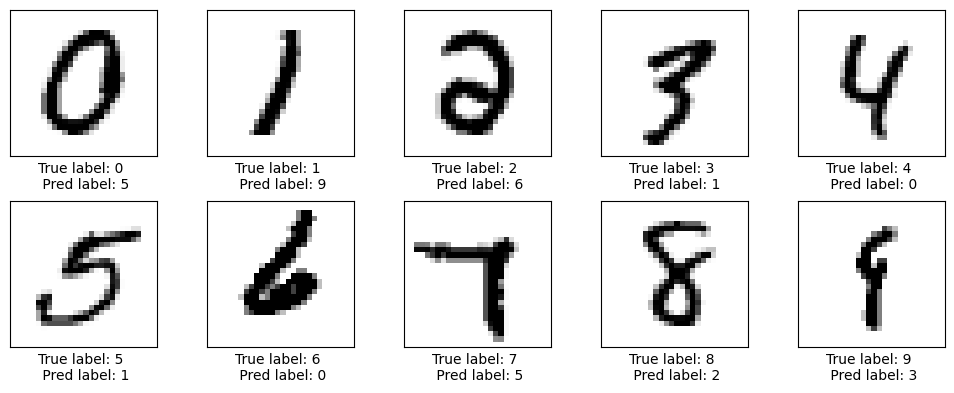

In [1]:
from mnist_model_test import random_read_mnist_csv, MNIST_nn_dummy, plot_images

csv_file = "mnist_sample.csv"  
selected_images, selected_labels = random_read_mnist_csv(csv_file)
# ------------ 在这里替换你的模型 --------------- #
mnist_model = MNIST_nn_dummy()
# ------------ 在这里替换你的模型 --------------- #
pred_labels = []
for img in selected_images:
    pred_labels.append(mnist_model.predict(img))

if pred_labels[0] == 0:
    print("Your model correctly predicted the '0' digit.")
else:
    print("Your model failed to predict.")
    
plot_images(selected_images, selected_labels, pred_labels)

### Step 2: Run for target digit

In [10]:
# A text box for the user to set the desired digit to find
target_digit_input = widgets.IntText(value=7, description="Target Digit")

# Labels to display real-time info
dot_label = widgets.Label(value="dot_in_center: False")
predict_label = widgets.Label(value="Predicted Digit: -")

# Show final results
time_label = widgets.Label(value="Elapsed Time: - s")
pos_label  = widgets.Label(value="Motor Position: - mm")

# Output area for logs
output_area = widgets.Output()

# Button to start the "contest"
run_contest_button = widgets.Button(description="Run Contest", button_style='info')

# State control for the background process
contest_running = False
contest1_stop_elapsed = None
contest1_stop_pos = None

def run_contest_button_clicked(_):
    global contest_running
    if contest_running:
        with output_area:
            output_area.clear_output(wait=True)
            print("Contest is already running!")
        return
    contest_running = True
    contest_loop()

def contest_loop():
    global contest_running, contest1_stop_elapsed, contest1_stop_pos
    with output_area:
        output_area.clear_output(wait=True)
        print(f"Motor is going home first!")
    motor.emergency_stop()
    motor.go_home()
    # Clear outputs
    with output_area:
        print("Starting contest... Make sure motor is homed & camera is running!")
    

    # For demonstration, let's run the motor at the current UI param values
    dire = motor_ui.dire_input.value
    acc  = motor_ui.acc_input.value
    spd  = motor_ui.speed_input.value

    # Start motor in continuous speed mode
    run_result = motor.run_motor(dire, acc, spd)
    max_time = 320 / 40 / spd * 60 # stop motor at the end in case of failing to detect
    with output_area:
        print(f"Motor started: {run_result}")
    start_time = time.time()
    # Poll the camera in a loop
    while contest_running:
        elapsed = time.time() - start_time
        # Record time
        time_label.value = f"Elapsed Time: {elapsed:.2f} s"
        # dot_in_center, color_change, nn_input_img
        dot_in_center, _, nn_input_img = cam_control.get_data()
        # Update label in UI
        # print(nn_input_img.shape)
        dot_label.value = f"dot_in_center: {dot_in_center}"

        if dot_in_center:
            if nn_input_img is not None:
                # ------------------ Predict digit --------------------- #
                pred_digit = mnist_model.predict(nn_input_img)
                predict_label.value = f"Predicted Digit: {pred_digit}"
                # ------------------------------------------------------ #
                # Check if predicted == target
                if pred_digit == target_digit_input.value:
                    # Stop motor
                    motor.emergency_stop()
                    # Read final motor position
                    pos = motor.read_physical_position()
                    pos_label.value = f"Motor Position: {pos:.2f} mm"
    
                    contest1_stop_elapsed = elapsed
                    contest1_stop_pos = pos 
                    with output_area:
                        print(f"Target digit {pred_digit} found -> motor stopped.")
                        print(f"Time: {elapsed:.2f}s, Position: {pos:.2f} mm")
    
                    contest_running = False
                    break
            else:
                predict_label.value = f"Predicted Digit: No image extracted!"
                    
        if elapsed > max_time:
            contest_running = False
            motor.emergency_stop()
            pos = motor.read_physical_position()
            with output_area:
                print(f"Failed to detect the number. Motor stopped due to max distance reached: {pos:.2f} mm.")
            break
        time.sleep(0.2)  

    with output_area:
        print("Contest ended!")


run_contest_button.on_click(run_contest_button_clicked)


# Build Two-Column UI
left_col = widgets.VBox([
    widgets.HTML("<b>Contest Controls</b>"),
    target_digit_input,
    run_contest_button
])

right_col = widgets.VBox([
    widgets.HTML("<b>Contest Status</b>"),
    dot_label,
    predict_label,
    time_label,
    pos_label,
])

ui_box = widgets.VBox([widgets.HBox([left_col, right_col]), output_area])
display(ui_box)

### Step 3: Configure your chemistry timing algorithm

In [11]:
# from xxx import composition_pred

def composition_pred(target_time):
    import random
    return random.randint(0,9)

target_time = 10 # s
print(f'The desired composition of solution should be {composition_pred(target_time)} g.')

The desired composition of solution should be 8 g.


### Step 4: Run for target timing

In [12]:
# Show final results
time_label = widgets.Label(value="Elapsed Time: - s")
pos_label  = widgets.Label(value="Motor Position: - mm")

# Output area for logs
output_area = widgets.Output()

# Button to start the "contest"
run_contest_button = widgets.Button(description="Run Contest", button_style='info')

# State control for the background process
contest_running = False
contest2_stop_elapsed = None
contest2_stop_pos = None

def run_contest_button_clicked(_):
    global contest_running
    if contest_running:
        with output_area:
            output_area.clear_output(wait=True)
            print("Contest is already running!")
        return
    contest_running = True
    contest_loop()

def contest_loop():
    global contest_running, contest2_stop_elapsed, contest2_stop_pos
    with output_area:
        output_area.clear_output(wait=True)
        print(f"Motor is going home first!")
    motor.emergency_stop()
    motor.go_home()
    # Clear outputs
    with output_area:
        output_area.clear_output(wait=True)
        print("Starting contest... Make sure motor is homed & camera is running!")
    
    # Example: read motor UI param values
    dire = motor_ui.dire_input.value
    acc  = motor_ui.acc_input.value
    spd  = motor_ui.speed_input.value
    max_time = 320 / 40 / spd * 60 # stop motor at the end in case of failing to detect
    # Start motor in continuous speed mode
    run_result = motor.run_motor(dire, acc, spd)
    with output_area:
        print(f"Motor started: {run_result}")

    start_time = time.time()

    # Poll the camera in a loop
    while contest_running:
        elapsed = time.time() - start_time
        time_label.value = f"Elapsed Time: {elapsed:.2f} s"

        # dot_in_center, color_change, nn_input_img
        _, color_change, _ = cam_control.get_data()

        if color_change:
            motor.emergency_stop()
            pos = motor.read_physical_position()
            contest2_stop_elapsed = elapsed
            contest2_stop_pos = pos 
            pos_label.value = f"Motor Position: {pos:.2f} mm"
            with output_area:
                print(f"Color changed => motor stopped.")
                print(f"Time: {elapsed:.2f}s, Position: {pos:.2f} mm")
            
            contest_running = False
            break
        if elapsed > max_time:
            contest_running = False
            motor.emergency_stop()
            pos = motor.read_physical_position()
            with output_area:
                print(f"Failed to detect the number. Motor stopped due to max distance reached: {pos:.2f} mm.")
            break
        time.sleep(0.2)  # check once per second

    with output_area:
        print("Contest ended!")

run_contest_button.on_click(run_contest_button_clicked)

# -------------------------
# Build Two-Column UI
# -------------------------
left_col = widgets.VBox([
    widgets.HTML("<b>Contest Controls</b>"),
    run_contest_button
])

right_col = widgets.VBox([
    widgets.HTML("<b>Contest Status</b>"),
    time_label,
    pos_label,
])

ui_box = widgets.VBox([widgets.HBox([left_col, right_col]), output_area])
display(ui_box)

### Step 5: Results calculation

In [14]:
if contest1_stop_pos is None or contest2_stop_pos is None:
    print('You must run each step sequentially before calculating your contest results!')
else:
    print(f'The difference between two runs is {abs(contest2_stop_pos-contest1_stop_pos)} mm! Thank you!')

You must run each step sequentially before calculating your contest results!
